# PERBANDINGAN METODE TRIPLE EXPONENTIAL SMOOTHING DAN AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA) PADA PERAMALAN HARGA CRYPTOCURRENCY (STUDI KASUS: LIMA KOIN KRIPTO TERATAS)

1. Set-Up
2. EDA
3. Data Preprocessing
4. Modelling
5. Hyperparameter Tuning
6. Evaluation


# SET-UP

## Import Library

In [39]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
import warnings
import time
warnings.filterwarnings("ignore")

#EDA
from tabulate import tabulate
# ouliers
from scipy import stats
# train test split
from pmdarima.model_selection import train_test_split

# metrics evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Data Hasil Prediksi Semua Dataset 5 Top Coin Crypto

In [114]:
# # Fungsi untuk membaca file CSV, mengganti nama kolom, dan mengatur indeks
def read_and_prepare_csv(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

#TES UNGGUL
data_btc = read_and_prepare_csv("CSV/BTC/BTC_tes_predictions_Close.csv")
data_bnb = read_and_prepare_csv("CSV/BNB/BNB_tes_predictions_Close.csv")
#ARIMA UNGGUL
data_eth = read_and_prepare_csv("CSV/ETH/ETH_arima_predictions_Close.csv")
data_sol = read_and_prepare_csv("CSV/SOL/SOL_arima_predictions_Close.csv")
data_xrp = read_and_prepare_csv("CSV/XRP/XRP_arima_predictions_Close.csv")

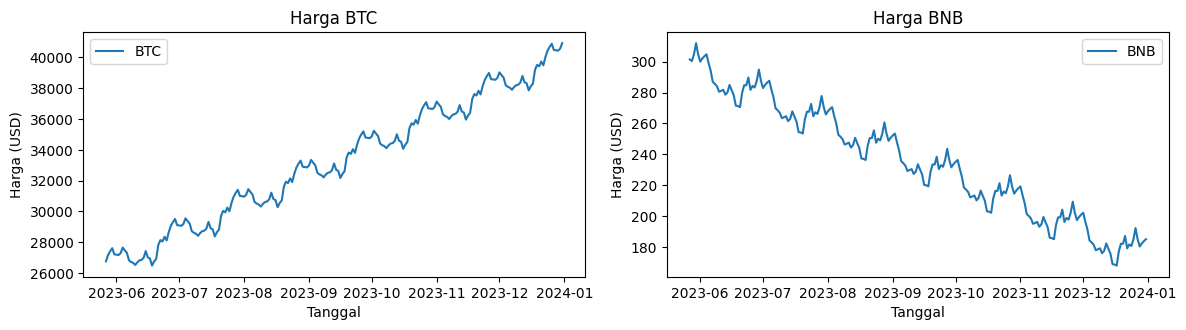

In [126]:
# Daftar koin dan data frames
coins = ['BTC', 'BNB',]
data_frames = [data_btc, data_bnb]

# Mengatur ukuran plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each coin's data
for i, (coin, df) in enumerate(zip(coins, data_frames)):
    axes[i].plot(df.index, df['Predicted'], label=coin)
    axes[i].set_title(f'Harga {coin}')
    axes[i].legend()

# Menambahkan label pada sumbu x dan y
for ax in axes:
    ax.set_xlabel('Tanggal')
    ax.set_ylabel('Harga (USD)')

# Hide the empty subplot
if len(coins) < len(axes):
    for j in range(len(coins), len(axes)):
        fig.delaxes(axes[j])

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()

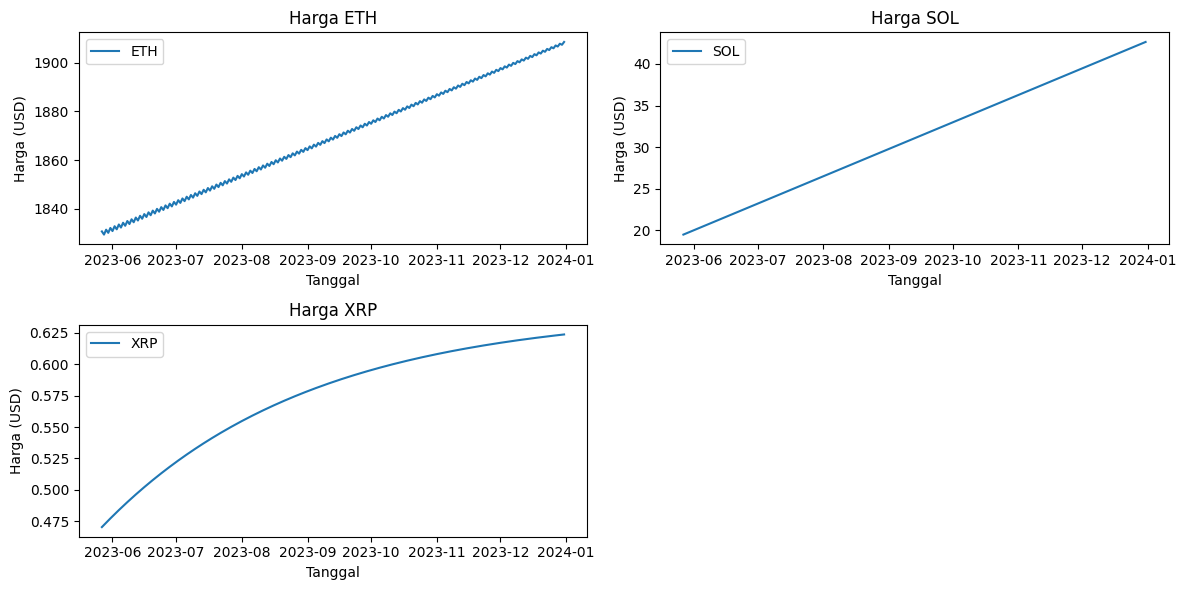

In [128]:
# Daftar koin dan data frames
coins = ['ETH', 'SOL', 'XRP']
data_frames = [data_eth, data_sol, data_xrp]

# Mengatur ukuran plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each coin's data
for i, (coin, df) in enumerate(zip(coins, data_frames)):
    axes[i].plot(df.index, df['Predicted'], label=coin)
    axes[i].set_title(f'Harga {coin}')
    axes[i].legend()

# Menambahkan label pada sumbu x dan y
for ax in axes:
    ax.set_xlabel('Tanggal')
    ax.set_ylabel('Harga (USD)')

# Hide the empty subplot
if len(coins) < len(axes):
    for j in range(len(coins), len(axes)):
        fig.delaxes(axes[j])

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()

In [130]:
# Merge data on the Date index
combined_data_TES = data_btc[['Predicted']].rename(columns={'Predicted': 'BTC'}).join(
                data_bnb[['Predicted']].rename(columns={'Predicted': 'BNB'}), how='outer')

combined_data_ARIMA = data_eth[['Predicted']].rename(columns={'Predicted': 'ETH'}).join(
                data_sol[['Predicted']].rename(columns={'Predicted': 'SOL'}), how='outer').join(
                data_xrp[['Predicted']].rename(columns={'Predicted': 'XRP'}), how='outer')                



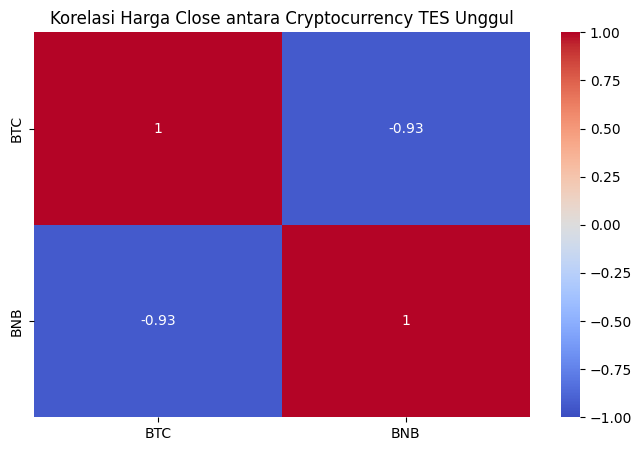

In [142]:
# Calculate the correlation matrix
correlation_matrix = combined_data_TES.corr()

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi Harga Close antara Cryptocurrency TES Unggul')
plt.show()

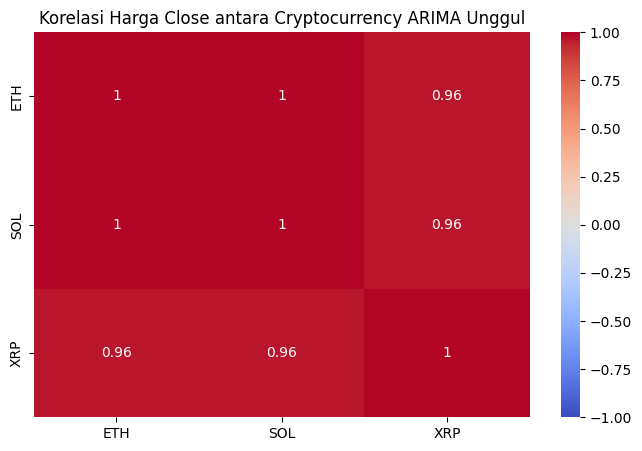

In [141]:
# Calculate the correlation matrix
correlation_matrix = combined_data_ARIMA.corr()

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi Harga Close antara Cryptocurrency ARIMA Unggul')
plt.show()

# EDA

In [5]:
# Read Data
combined_data

,BTC,ETH,BNB,SOL,XRP
Date,,,,,
2021-01-01,29374.152344,730.367554,37.905010,1.842084,0.237444
2021-01-02,32127.267578,774.534973,38.241592,1.799275,0.221655
2021-01-03,32782.023438,975.507690,41.148979,2.161752,0.225848
2021-01-04,31971.914063,1040.233032,40.926353,2.485097,0.236677
2021-01-05,33992.429688,1100.006104,41.734600,2.157217,0.226750
...,...,...,...,...,...
2023-12-27,43442.855469,2378.739990,323.677338,107.023796,0.634856
2023-12-28,42627.855469,2347.566162,323.598999,102.104568,0.634998
2023-12-29,42099.402344,2300.690674,313.878754,106.311516,0.623402


In [6]:
combined_data.describe().T

,count,mean,std,min,25%,50%,75%,max
BTC,1095.0,34831.378123,12556.081916,15787.284180,24693.675781,32186.277344,43551.312500,67566.828125
ETH,1095.0,2186.967729,863.545155,730.367554,1606.941834,1871.005127,2700.552368,4812.087402
BNB,1095.0,323.091985,117.789668,37.905010,245.882447,302.985596,385.168579,675.684082
SOL,1095.0,55.782474,55.221616,1.799275,20.926327,32.465298,74.051685,258.934326
XRP,1095.0,0.631261,0.287855,0.221655,0.408562,0.524204,0.777336,1.839236


In [7]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2021-01-01 to 2023-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     1095 non-null   float64
 1   ETH     1095 non-null   float64
 2   BNB     1095 non-null   float64
 3   SOL     1095 non-null   float64
 4   XRP     1095 non-null   float64
dtypes: float64(5)
memory usage: 51.3 KB


# Evaluation

## Export Data

## Data Frame with Actual & Predicted

In [38]:
import openpyxl
# Create a DataFrame with Actual and Predicted values for TES & ARIMA Model (Compare)
df_prediksi_compare = pd.DataFrame({'Harga Aktual': hw_test_df['Close_interpolated'], 'Prediksi TES': Tuning_TES, 'Prediksi ARIMA': Tuning_ARIMA, 'Selisih TES':df_prediksi_TES['Perbedaan Absolut'], 'Selisih ARIMA':df_prediksi_ARIMA['Perbedaan Absolut']})

#save to excel
df_prediksi_compare.to_excel('Compare_predictions_Close.xlsx', index=True)

df_prediksi_compare

,Harga Aktual,Prediksi TES,Prediksi ARIMA,Selisih TES,Selisih ARIMA
2023-05-27,26868.353516,26763.391948,26579.796663,104.961568,288.556853
2023-05-28,28085.646484,27166.482881,26649.241718,919.163603,1436.404766
2023-05-29,27745.884766,27413.452656,26705.542022,332.432110,1040.342744
2023-05-30,27702.349609,27614.019036,26705.595491,88.330573,996.754118
2023-05-31,27219.658203,27215.063898,26745.041209,4.594305,474.616994
...,...,...,...,...,...
2023-12-27,43442.855469,40481.125451,32909.616951,2961.730018,10533.238518
2023-12-28,42627.855469,40462.780510,32938.973073,2165.074959,9688.882396
2023-12-29,42099.402344,40434.891537,32968.329196,1664.510807,9131.073148
2023-12-30,42156.902344,40556.505730,32997.685318,1600.396614,9159.217026


## Kesimpulan

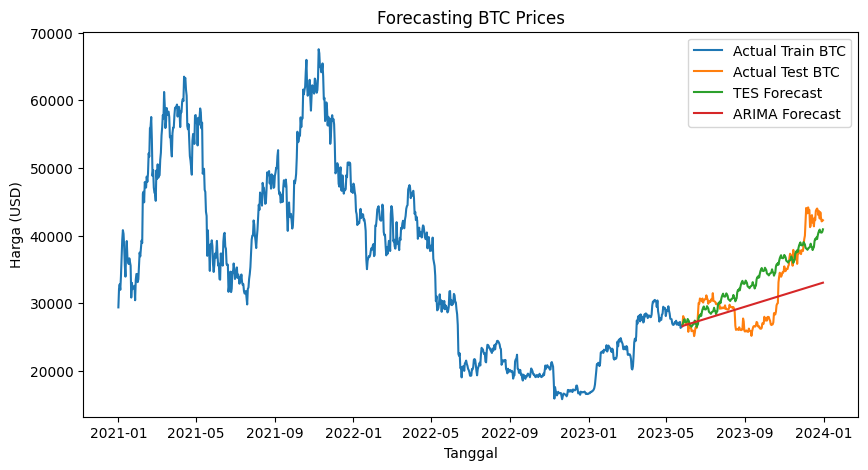

| Model   |    RMSE | MAPE   |
|:--------|--------:|:-------|
| TES     | 4130.77 | 10.93% |
| ARIMA   | 4731.45 | 10.95% |


In [45]:
# Plotting the forecasts
plt.figure(figsize=(10, 5))
plt.plot(train_final['Close_interpolated'], label='Actual Train BTC')
plt.plot(arima_test_df['Close_interpolated'], label='Actual Test BTC')
plt.plot(Tuning_TES, label='TES Forecast')
plt.plot(Tuning_ARIMA, label='ARIMA Forecast')
plt.legend()
plt.title('Forecasting BTC Prices')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.show()

comparison_df = pd.DataFrame({
    'Model': ['TES','ARIMA'],
    'RMSE': [ rmse_tuned_TES, rmse_tuned_ARIMA ],
    'MAPE': [ (f'{mape_tuned_TES:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')]
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

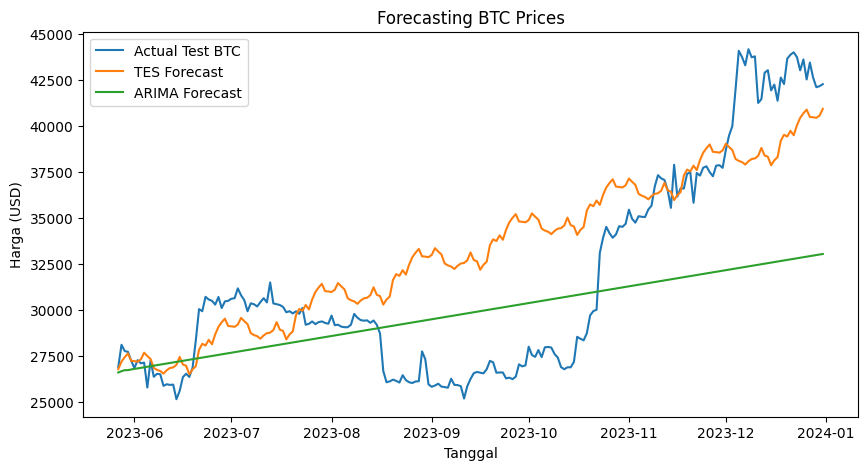

| Model   |    RMSE | MAPE   |
|:--------|--------:|:-------|
| TES     | 4130.77 | 10.93% |
| ARIMA   | 4731.45 | 10.95% |


In [40]:
# Plotting the forecasts
plt.figure(figsize=(10, 5))
plt.plot(arima_test_df['Close_interpolated'], label='Actual Test BTC')
plt.plot(Tuning_TES, label='TES Forecast')
plt.plot(Tuning_ARIMA, label='ARIMA Forecast')
plt.legend()
plt.title('Forecasting BTC Prices')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.show()

comparison_df = pd.DataFrame({
    'Model': ['TES','ARIMA'],
    'RMSE': [ rmse_tuned_TES, rmse_tuned_ARIMA ],
    'MAPE': [ (f'{mape_tuned_TES:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')]
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

In [41]:
comparison_df = pd.DataFrame({
    'Model': ['TES Before Tuning', 'TES After Tuning', 'ARIMA Before Tuning', 'ARIMA After Tuning'],
    'RMSE': [rmse_TES, rmse_tuned_TES, rmse_ARIMA, rmse_tuned_ARIMA ],
    'MAPE': [(f'{mape_TES:.2f}%'), (f'{mape_tuned_TES:.2f}%'), (f'{mape_ARIMA:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')],
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model               |    RMSE | MAPE   |
|:--------------------|--------:|:-------|
| TES Before Tuning   | 8540.2  | 16.29% |
| TES After Tuning    | 4130.77 | 10.93% |
| ARIMA Before Tuning | 7390.74 | 13.74% |
| ARIMA After Tuning  | 4731.45 | 10.95% |


In [42]:
comparison_df = pd.DataFrame({
    'Model': ['TES Tuning','ARIMA Tuning'],
    'RMSE': [ rmse_tuned_TES, rmse_tuned_ARIMA ],
    'MAPE': [ (f'{mape_tuned_TES:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')]
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model        |    RMSE | MAPE   |
|:-------------|--------:|:-------|
| TES Tuning   | 4130.77 | 10.93% |
| ARIMA Tuning | 4731.45 | 10.95% |


Kesimpulan

Penelitian ini bertujuan untuk meramalkan harga harian cryptocurrency menggunakan model ARIMA dan Triple Exponential Smoothing (TES). Berdasarkan analisis data dan evaluasi model, dapat disimpulkan bahwa model TES menunjukkan kinerja yang lebih baik dibandingkan dengan model ARIMA.

Hasil evaluasi menunjukkan bahwa TES memiliki RMSE sebesar 4130.77 dan MAPE sebesar 10.93%, sementara ARIMA memiliki RMSE sebesar 4731.45 dan MAPE sebesar 10.95%. Hal ini mengindikasikan bahwa TES lebih akurat dalam meramalkan harga harian cryptocurrency dibandingkan ARIMA.

Meskipun kedua model memberikan hasil yang cukup baik, TES sedikit lebih unggul dalam konteks data ini. Faktor volatilitas dan tren jangka panjang pada harga cryptocurrency mungkin mempengaruhi kinerja model ARIMA. Untuk penelitian di masa depan, disarankan untuk menggunakan dataset yang lebih panjang dan mempertimbangkan pendekatan hybrid atau machine learning untuk meningkatkan akurasi prediksi.

Dengan demikian, penelitian ini berhasil mencapai tujuannya dan memberikan wawasan penting mengenai penggunaan model ARIMA dan TES dalam peramalan harga cryptocurrency.


In [43]:
#Save Model
import pickle
pickle.dump(model, open('model_TES_ARIMA.pkl','wb'))